### Ergodic Metric Using iLQR

In [2]:
#import necessary packages 
import numpy as np
from numpy.linalg import det 
from numpy.linalg import norm
from numpy.linalg import inv 

import math
from math import cos
from math import pi 
from math import sin 
from math import exp

from scipy.integrate import simpson


import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
def subspace(distribution):
    '''
    Get the boundaries of a subspace given a n x m distribution in n-dimensional space.

    Parameters
    ----------
    trajectory: np.array
        This is a n x m distribution in n-dimensional space over m samples
    
    Returns
    -------
    bounds: np.array
        This is a 2 x n array that descibes the limits in x_1, x_2, .. x_n dimensions. 
    '''
    #get the dimensions of the trajectory.
    n, m = distribution.shape

    #intitialize bounds to be a 2 x n matrix. 
    bounds = np.ndarray((2,n))

    #set the minimums on top and the maximums on the bottom.
    #round to nice even numbers
    bounds[0, :] = np.floor(np.amin(distribution, axis=1))
    bounds[1, :] = np.ceil(np.amax(distribution, axis=1))

    return bounds

In [122]:
#Distribution and Initialization of Constants---------------------------------
#creation of the distribution
mu = np.zeros((2))
covar= np.diag((2,2))
target = np.random.multivariate_normal(mu, covar, 100000).T
bounds = subspace(target)

#creation of our time boundary 
t = 10
timestep = 100
time, dt = np.linspace(0,t,timestep,retstep=True)

#create the guess, trajectory, and controls
#initial control guess
cont_guess = np.vstack((np.full_like(time, 1), np.full_like(time, -1)))
traj_guess = np.zeros((2 * time.size))
traj_guess[0:2] = np.array([0, 1])

#update our trajectory based on our control signals
for i in range(0,len(traj_guess)-2, 2):
    #calculate the states based on the control velocities.
    ii = int(i/2)
    traj_guess[i + 2] = traj_guess[i]       + dt * cont_guess[0, ii]
    traj_guess[i + 3] = traj_guess[i + 1]   + dt * cont_guess[1, ii]

#reshape to represent states. 
traj_guess = traj_guess.reshape(time.size, 2).T

#initial guess
initial_guess = np.concatenate((traj_guess, cont_guess))
state_dict = dict(zip(time,initial_guess.T))

In [123]:
def fourier(k, L, x, n):
    '''
    Fourier will take the approximation of a singular n-dimensional k, using the basis function.

    Parameters
    ----------
    k : np.array
        This a singular n-dimensional index for Fourier coefficients.
    L: np.array
        Upper and lower bounds of an n-dimensional search space.
    x: np.array
        Trajectory point.
    n: int
        Number of dimensions in search space. 
    
    Returns
    -------
    prod: float
        Value of the Fourier Basis Function at that index, w.r.t trajectory point.
    '''
    #make sure that k is the same dimensionality as n 
    #also makes sure that k is a numpy array.
    if np.shape(k)[0] != n:
        raise TypeError("Wanted k to be np.array of size n")
    
    if np.shape(x)[0] != n:
        raise TypeError("Wanted x to be np.array of size n")
    
    if np.shape(L) != (2,n):
        raise TypeError("Wanted L to be np.array of size n")
    
    #find h_k. 
    h_k = 1 

    #find the product over the n-dimensional space based on the given
    #k and x(t)
    prod = 1 

    for i in range(n):
        prod *= cos((k[i] * pi)/(L[1, i] - L[0, i]) * (x[i] - L[0, i]))
    
    #return the product normalized by the h_k facotr.
    prod = 1/h_k * prod
    
    return prod

def phi_k(boundary, mu, cv, resolution, KF):
    '''
    Define phi_k over the bounds over a normally distributed Guassian distribution with 
    mu and covariance.

    Parameters
    ----------
    boundary: np.array
        This is a 2 x n distribution in n-dimensional space. Assumes [0,:] is minimums,
        [1,:] is maximums.

    mu: np.array
        This is a n-dimensional array of the Guassian distribution mean. 

    cv: np.array
        This is an n x n dimensional array of the Guassian distribution covariance.

    resolution: integer
        This tells us how fine our mesh should be in the distribution discretization    

    k_F: integer
        This tells us how many Fourier coefficients we will have.
    
    Returns
    -------
    pk: np.array
        This is a k_F by k_F dimensioned array of coefficients. 
    '''
    #set up our index arrays for the Fourier Coefficients.
    k = np.array([KF, KF])
    rows, cols = np.indices((k[0],k[1]))

    #intitialize the pk storage.
    pk = np.zeros((k[0],k[1]))

    #create the grid between the boundaries to the specified resolution.
    rangex, dx = np.linspace(boundary[0,0], boundary[1,0] + 1, resolution, retstep=True)
    rangey, dy = np.linspace(boundary[0,1], boundary[1,1] + 1, resolution, retstep=True)
    sub_x, sub_y = np.meshgrid(rangex, rangey)

    #iterate over our subspace indices.
    for ii in range(sub_x.shape[0]):        #number of rows
        for jj in range(sub_y.shape[1]):    #number of columns
            sub_index = np.array([sub_x[ii, jj], sub_y[ii, jj]])

            #find the px value for the given sub_index.
            px = det(2 * pi * cv)**-0.5 * exp(-0.5 * ((sub_index - mu).T) @ inv(cv) @ (sub_index - mu))

            #iterate over our fourier basis coefficient indices.
            for i in range(k[0]):
                for j in range(k[1]):

                    #fourier only accepts numpy arrays, so we convert into an index.
                    k_index = np.array([rows[i,j],cols[i,j]])

                    #find the pk matrix for the given timestep.         
                    pk[i,j] += px * fourier(k_index, boundary, sub_index, 2) * dy * dx

    return pk

In [124]:
def metric(trajectory, bounds, time, dt, phi_k):
    '''
    Define the cost of the ergodicity of a trajectory.

    Parameters
    ----------
    trajectory: np.array
        This a n x m trajectory in n-dimensional space over m timesteps

    bounds: np.array
        This is a 2 x n distribution in n-dimensional space. Assumes [0,:] is minimums,
        [1,:] is maximums.

    time: np.array
        This is a m shaped array.
    
    dt: float
        Timestep.

    phi_k: np.array
        This is a k_F by k_F dimensioned array of coefficients. 

    q: float
        This tells us how much to weigh our ergodic metric in the cost function

    R: np.array
        Must be n x n dimensions. Weighs importance control signals.

    u: np.array
        This a n x m control array in n-dimensional space over m timesteps
    
    P1: np.array
        Must be n x n dimensions.
        
    Returns
    -------
    cost: float
        A measure of the current cost based on the ergodic metric.
    '''
    #create our ck array.
    n, m = phi_k.shape
    ck = np.zeros((n, m))

    #create an indexable array of Fourier Coefficients.
    k = np.array([n,m])
    rows, cols = np.indices((n, m))

    #find ck using Fourier Basis Functions
    for ii in range(trajectory.shape[1]):
        #iterate over the indices that we have.
        for i in range(n):
            for j in range(m):
                #fourier only accepts numpy arrays so we convert into an index.
                index = np.array([rows[i,j],cols[i,j]])

                #find the ck matrix for the given timestep
                ck[i, j] += fourier(index, bounds, trajectory[:, ii], 2) * dt

    #finsih the integral
    ck = 1/time[-1] * ck    

    #define the ergodic metric
    lamb = (1 + norm(k)**2)**(-1 * ((2 + 1) / 2)) 

    #define the difference between the ck matrix and the pk matrix
    diff = np.subtract(ck, phi_k)

    return diff

In [125]:
def A(t): 
    x, y, u1, u2 = state_dict[t]
    return np.array([[0, 0 ],
                     [0, 0 ]
                     ]) 
                     
def B(t): 
    x, y, u1, u2 = state_dict[t]
    return np.array([[1, 0],
                     [0, 1]
                     ]) 

def euler(P1, Q, R, t, dt):
    #Create the P array based on the time size.
    P = np.ndarray((4, t.size))

    #Assign the terminal condition to the end of the array. 
    P[:,-1] = P1.flatten()

    #Find the slope and work backwards using Euler's integration. 
    for i in range(t.size-1, 0, -1):
        #Find the current P matrix that we have and reshape it for matmul.
        cP = P[:,i].reshape(2,2)

        #Find the slope.
        Pdot = cP @ A(t[i]) + A(t[i]).T @ cP - cP @ B(t[i]) @ inv(R) @ B(t[i]).T @ cP + Q

        #Perform Euler's Inegration and update the next step.
        P[:, i-1] = (cP + Pdot * dt).flatten()

    return P

In [126]:
def DFourier(k, state, bounds):
    #we expect that k will be a np.array
    #we expect that state will be a np.array
    
    #unpack the bounds 
    k1, k2 = k[:]
    x, y = state[:]

    xmin, xmax = bounds[:,0]
    ymin, ymax = bounds[:,1]

    #define our h_k 
    h_k = 1 

    #create our storage space 
    val = np.ndarray((2,))

    #assign the values.
    val[0] = -1/h_k * sin((k1 * pi)/(xmax - xmin) * (x - xmin)) * cos((k2 * pi)/(ymax - ymin) * (y - ymin))  
    val[1] = -1/h_k * cos((k1 * pi)/(xmax - xmin) * (x - xmin)) * sin((k2 * pi)/(ymax - ymin) * (y - ymin))

    #return our vector
    return val

def DFArray(bounds, state, KF):
    #create our holding array
    DFK = np.zeros((KF, KF, 2))
    n, m, z = DFK.shape

    #create an indexable array of Fourier Coefficients 
    k = np.array([n,m])
    rows, cols = np.indices((n, m))

    #iterate over the indexes of the entire Fourier Coefficient Array
    for i in range(n):
        for j in range(m):
            #Dfourier only accepts numpy arrays so we convert into an index.
            index = np.array([rows[i,j],cols[i,j]])

            #find the DFK matrix for the given timestep
            DFK[i, j, :] += DFourier(index, state, bounds)
    return DFK

In [127]:
def a(t, q, diff, bounds, KF, T):
    #t is the time at which we are solving.
    #T is the time horizon
    
    #setup the state based on the given timestep.
    x, y, u1, u2 = state_dict[t]
    state = np.array([x, y])

    #setup the array that will be used to calculate our lambda
    k = np.array([KF, KF])
    lamb = (1 + norm(k)**2)**(-1 * ((2 + 1) / 2)) 

    #multiply the diff matrix elementwise by the matrix that we generate
    #by solving the differential Fourier Basis Functions
    DFk = DFArray(bounds, state, KF)
    DFk = 1/T * DFk

    #This is the elementwise multiplication
    DFk[:,:,0] = np.multiply( diff, DFk[:, :, 0])
    DFk[:,:,1] = np.multiply( diff, DFk[:, :, 1])

    #This is the summation over the pages of the matrix. Will output
    #a 2 x 1
    interior = q * np.sum(2 * lamb * DFk, axis=(0,1))
    return interior.reshape(2,1)




def b(t, R):
    x, y, u1, u2 = state_dict[t]
    control = np.array([u1, u2])
    
    return (control @ R).reshape(2,1)




def r_integrate(r0, P, t, dt, q, diff, bounds, KF):
    #Create the r array based on the time size. 
    r = np.ndarray((2,t.size))

    #Assign the terminal condition to the end of the array. 
    r[:,-1] = r0

    #Find the slope and work backwards using Euler's integration. 
    for i in range(t.size-1, 0, -1):
        #Find the current r matrix that we have and reshape it for matmul.
        cr = r[:,i,None]

        #Find the slope.
        rdot = (A(t[i]) - B(t[i]) @ inv(R) @ B(t[i]).T @ P[:,i].reshape(2,2)).T @ cr + a(t[i], q, diff, bounds, KF, t[-1]) - P[:,i].reshape(2,2) @ B(t[i]) @ inv(R) @ b(t[i],R)

        #Perform Euler's Inegration and update the next step.
        r[:, i-1] = (cr + rdot * dt).flatten()
    return r



def z_integrate(z0, P, r, t, dt):
    #Create the z array based on the time size. 
    z = np.ndarray((2,t.size))

    #Assign the intitial condition to the beginning of the array. 
    z[:,0] = z0

    #Find the slope and work forwards using Euler's integration. 
    for i in range(0, t.size-1, 1):
        #Find the current z matrix that we have and reshape it for matmul.
        cz = z[:,i,None]

        #Find the slope.
        zdot = A(t[i]) @ cz + B(t[i]) @ (-1 * inv(R) @ B(t[i]).T @ P[:,i].reshape(2,2) @ cz - inv(R) @ B(t[i]).T @ r[:,i,None] - inv(R) @ b(t[i],R))
        # zdot = A(t[i]) @ cz + B(t[i]) @ (-1 * inv(R) @ B(t[i]).T @ P[:,i].reshape(3,3) @ cz  - inv(R) @ b(t[i],R))

        #Perform Euler's Inegration and update the next step.
        z[:, i+1] = (cz + zdot * dt).flatten()
    return z

def zi(z0, t, dt):
    #Create the z array based on the time size. 
    z = np.ndarray((2,t.size))

    #Assign the intitial condition to the beginning of the array. 
    z[:,0] = z0

    #Find the slope and work forwards using Euler's integration. 
    for i in range(0, t.size-1, 1):
        #Find the current z matrix that we have and reshape it for matmul.
        cz = z[:,i,None]

        #Find the slope.
        zdot = A(t[i]) @ cz + B(t[i]) @ (- inv(R) @ b(t[i],R))
        # zdot = A(t[i]) @ cz + B(t[i]) @ (-1 * inv(R) @ B(t[i]).T @ P[:,i].reshape(3,3) @ cz  - inv(R) @ b(t[i],R))

        #Perform Euler's Inegration and update the next step.
        z[:, i+1] = (cz + zdot * dt).flatten()
    return z


def vi(t):
    #Create the z array based on the time size. 
    v = np.ndarray((2,t.size))

    #Find the v values based on the current time step. 
    for i in range(0, t.size, 1):
        #Assign the value of v. 
        v[:, i] = (- inv(R) @ b(t[i],R)).flatten()
        # v[:, i] = (-1 * inv(R) @ B(t[i]).T @ P[:,i].reshape(3,3) @ z[:,i, None]  - inv(R) @ b(t[i],R)).flatten()

    return v 


def v_integrate(P, r, z, t):
    #Create the z array based on the time size. 
    v = np.ndarray((2,t.size))

    #Find the v values based on the current time step. 
    for i in range(0, t.size, 1):
        #Assign the value of v. 
        v[:, i] = (-1 * inv(R) @ B(t[i]).T @ P[:,i].reshape(2,2) @ z[:,i, None] - inv(R) @ B(t[i]).T @ r[:,i,None] - inv(R) @ b(t[i],R)).flatten()
        # v[:, i] = (-1 * inv(R) @ B(t[i]).T @ P[:,i].reshape(3,3) @ z[:,i, None]  - inv(R) @ b(t[i],R)).flatten()

    return v 

In [128]:
def J(trajectory, bounds, time, dt, phi_k, q, R, u):
    '''
    Define the cost of the ergodicity of a trajectory.

    Parameters
    ----------
    trajectory: np.array
        This a n x m trajectory in n-dimensional space over m timesteps

    bounds: np.array
        This is a 2 x n distribution in n-dimensional space. Assumes [0,:] is minimums,
        [1,:] is maximums.

    time: np.array
        This is a m shaped array.
    
    dt: float
        Timestep.

    phi_k: np.array
        This is a k_F by k_F dimensioned array of coefficients. 

    q: float
        This tells us how much to weigh our ergodic metric in the cost function

    R: np.array
        Must be n x n dimensions. Weighs importance control signals.

    u: np.array
        This a n x m control array in n-dimensional space over m timesteps
    
    P1: np.array
        Must be n x n dimensions.
        
    Returns
    -------
    cost: float
        A measure of the current cost based on the ergodic metric.
    '''
    #create our ck array.
    n, m = phi_k.shape

    ck = np.zeros((n, m))

    #create an indexable array of Fourier Coefficients.
    k = np.array([n,m])
    rows, cols = np.indices((n, m))

    #find ck using Fourier Basis Functions
    for ii in range(trajectory.shape[1]):
        #iterate over the indices that we have.
        for i in range(n):
            for j in range(m):
                #fourier only accepts numpy arrays so we convert into an index.
                index = np.array([rows[i,j],cols[i,j]])

                #find the ck matrix for the given timestep
                ck[i, j] += fourier(index, bounds, trajectory[:, ii], 2) * dt

    #finsih the integral
    ck = 1/time[-1] * ck    

    #define the ergodic metric
    lamb = (1 + norm(k)**2)**(-1 * ((2 + 1) / 2)) 
    epsilon = np.sum(lamb * (np.subtract(ck, phi_k))**2)

    #calculate the integral 
    integral = np.ndarray((time.size)) 
    for i in range(0, time.size, 1):
        integral[i] = u[:,i,None].T @ R @ u[:,i,None]

    #get the cost
    cost = q * epsilon + simpson(integral, time)
    return cost




def dJ(diff, bounds, q, t, z, v, R, KF):
    #create where we are going to store our array
    integral = np.ndarray((time.size)) 

    #Iterate over the time array
    for i in range(0, t.size, 1):
        integral[i] = a(t[i], q, diff, bounds, KF, t[-1]).T @ z[:, i, None] + b(t[i],R).T @ v[:, i, None]

    #integrate
    out = simpson(integral, time)
    return out

In [129]:
#Begin solving the Ricotti Equations. 
P_All = euler(P1, Q, R, time, dt)

#solve the diff matrix using metric
diff = metric(initial_guess[0:2,:], bounds, time, dt, pk)

#Begin solving for r based on the terminal condition. 
r_All = r_integrate(rT, P_All, time, dt, 1, diff, bounds, 10) 

#Begin solving for z based on the initial condtion. Solve for v, once we have z. 
z_All = z_integrate(z0, P_All, r_All, time, dt)
v_All = v_integrate(P_All, r_All, z_All, time)

# zi_All = zi(z0, time, dt)
# vi_All = vi(time)


cost = J(initial_guess[0:2,:], bounds, time, dt, pk, 1, R, initial_guess[2:4])
d_J = dJ(diff, bounds, 1, time, z_All, v_All, R, 10)

print(cost)
print(d_J)

1.253452643638358
0.12761254566400726


In [130]:
##Setup our constants
Q  = np.diag([1,1])

#When r is equal to zero then Q must be equal to P1
R  = np.diag([1,1])
P1 = np.diag([0,0])

#The terminal condition for r is that it is equal to zero. 
# rT = np.zeros((2,))
# rT = np.ones((2,))    #First curvature in line
rT = np.array([1, 0])

#The initial condition for z is that it is equal to zero.
z0 = np.zeros((2,))

#calculate the pk over the entire domain
pk = phi_k(bounds, mu, covar, 100, 10)

In [131]:
##iLQR Algorithm---------------------------------------------------------------------------------------------
#Initialize the constants that we need. 
alpha = 0.4 
beta = 0.7
epsilon = 10 ** -7
q = 1 

#iterators
xi = 1
j = 0 

#Create our changing trajectory.
trajectory = np.copy(initial_guess)
controls = np.copy(cont_guess)

#Create an objective function list. 

ob_Arr = []
obj_Arr = []

while xi > epsilon: 
    #Begin solving the Ricotti Equations. 
    P_All = euler(P1, Q, R, time, dt)

    #solve the diff matrix using metric
    diff = metric(trajectory[0:2,:], bounds, time, dt, pk)

    #Begin solving for r based on the terminal condition. 
    r_All = r_integrate(rT, P_All, time, dt, 1, diff, bounds, 10) 

    #Begin solving for z based on the initial condtion. Solve for v, once we have z. 
    z_All = z_integrate(z0, P_All, r_All, time, dt)
    v_All = v_integrate(P_All, r_All, z_All, time)
    # zi_All = zi(z0, time, dt)
    # vi_All = vi(time)

    #Compute the current cost of the trajectory and the directional derivative in the new direction.
    cost = J(trajectory[0:2,:], bounds, time, dt, pk, 1, R, trajectory[2:4])
    #d_J = dJ(diff, bounds, 1, time, z_All, v_All, R, 10)
    d_J = dJ(diff, bounds, 1, time, z_All, v_All, R, 10)

    #Add the current objective.
    obj_Arr.append(cost)

    print("initial cost is:", cost)
    print("intial directional is:", d_J)

    n = 0 
    maxiter = 0
    gamma = beta ** n 

    #Compute the descent direction based on the new direction z, v. 
    while True:
        print("n is:",n)
        #Update the controls
        temp_controls = controls + gamma * v_All

        #Update the trajectory based on the new controls.
        update = np.zeros((2 * time.size))
        update[0:2] = np.array([0, 1])

        #update our trajectory based on our control signals
        for i in range(0,len(update)-2, 2):
            #calculate the states based on the control velocities.
            ii = int(i/2)
            update[i + 2] = update[i]       + dt * temp_controls[0, ii]
            update[i + 3] = update[i + 1]   + dt * temp_controls[1, ii]

        #reshape to represent states. 
        update = update.reshape(time.size, 2).T

        #concatenate the controls
        update = np.concatenate((update, temp_controls))

        #Find the cost of the new trajectory. 
        updated_cost = J(update[0:2,:], bounds, time, dt, pk, 1, R, update[2:4,:])
        ob_Arr.append(updated_cost)
        print("updated_cost is", updated_cost)
        print("condition is:", cost + alpha * gamma * d_J)

        #Break out of the loop if our condition is met or if we have had too many iterations. 
        if updated_cost < cost + alpha * gamma * d_J:
            break 

        maxiter += 1
        if maxiter > 1000:
            break

        #If we don't break out of the loop, we just do it again. 
        n += 1 
        gamma = beta ** n 

    #Exit the loop if we have too many iterations. 
    if maxiter > 1000:
        break
    
    #When we break out of the loop.
    #Update our trajectory and the dictionary so that we can continue iterating. 
    trajectory = np.copy(update)

    #Update our controls based on our new trajectory.
    controls = trajectory[2:4,:]

    #Update the dictionary being called so that the loop can continue iterating.
    state_dict = dict(zip(time,trajectory.T)) 
    
    j += 1
    xi = abs(dJ(diff, bounds, 1, time, z_All, v_All, R, 10))
    print("j is:",j)
        

initial cost is: 1.2539438933301712
intial directional is: 0.12762787896565364
n is: 0
updated_cost is 1.8371001235395406
condition is: 1.3049950449164327
n is: 1
updated_cost is 1.593295410408135
condition is: 1.2896796994405542
n is: 2
updated_cost is 1.457751416481813
condition is: 1.2789589576074394
n is: 3
updated_cost is 1.3800777919922076
condition is: 1.271454438324259
n is: 4
updated_cost is 1.3341373960028309
condition is: 1.2662012748260325
n is: 5
updated_cost is 1.3061102744669624
condition is: 1.2625240603772743
n is: 6
updated_cost is 1.2885155269512403
condition is: 1.2599500102631433
n is: 7
updated_cost is 1.2771910719832866
condition is: 1.2581481751832517
n is: 8
updated_cost is 1.2697499666156735
condition is: 1.2568868906273276
n is: 9
updated_cost is 1.2647793385788964
condition is: 1.2560039914381806
n is: 10
updated_cost is 1.261416590140036
condition is: 1.255385962005778
n is: 11
updated_cost is 1.2591198448462744
condition is: 1.2549533414030958
n is: 12
upd

KeyboardInterrupt: 

Text(0.5, 1.0, 'Objective Overall')

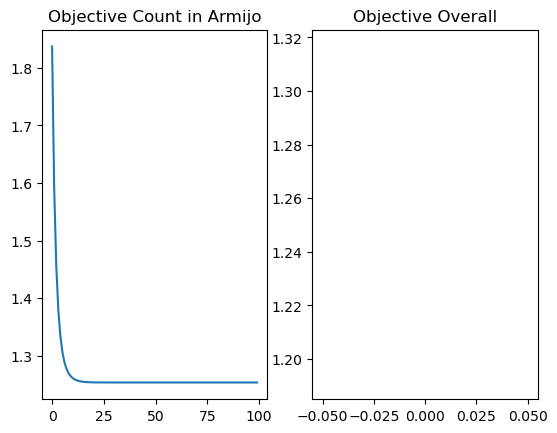

In [132]:
##Plots-------------------------------------------------------------------------------------------------
fig, axs = plt.subplots(1,2)
#Plotting the reference trajectory
axs[0].plot(ob_Arr[0:100])
axs[0].set_title("Objective Count in Armijo")

#Plotting the control signal 
axs[1].plot(obj_Arr, "tab:orange")
axs[1].set_title("Objective Overall")

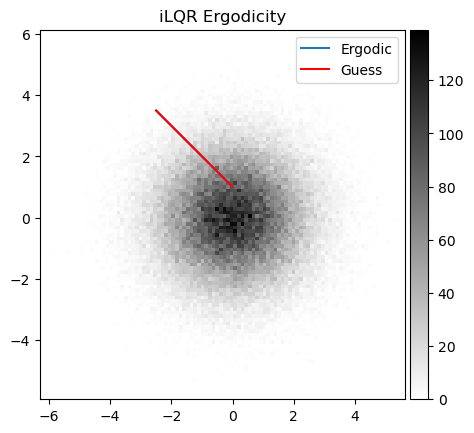

In [133]:

##Plots-------------------------------------------------------------------------------------------------
fig, axs = plt.subplots()
divider = make_axes_locatable(axs) 

#Creation of the colormap and the colorbar. 
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs.hist2d(target[0,:], target[1,:], bins=100, cmap="binary")
fig.colorbar(im[3], cax=cax, orientation='vertical')
axs.set_aspect("equal")
axs.set_title("Distribution")

# #Plot the intitial distribution on the second figure.
# axs[1].scatter(target[0,:], target[1,:], c='orange')
# axs[1].axis("equal")
# axs[1].set_title("Samples")

#Plot the trajectory as well. 
axs.plot(trajectory[0, :],trajectory[1, :], label="Ergodic")
axs.axis("equal")
axs.set_title("iLQR Ergodicity")

#Plot the initial trajectory
axs.plot(traj_guess[0, :],traj_guess[1, :], color="red", label="Guess")
axs.legend()